Processing 1970–1974 ...


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


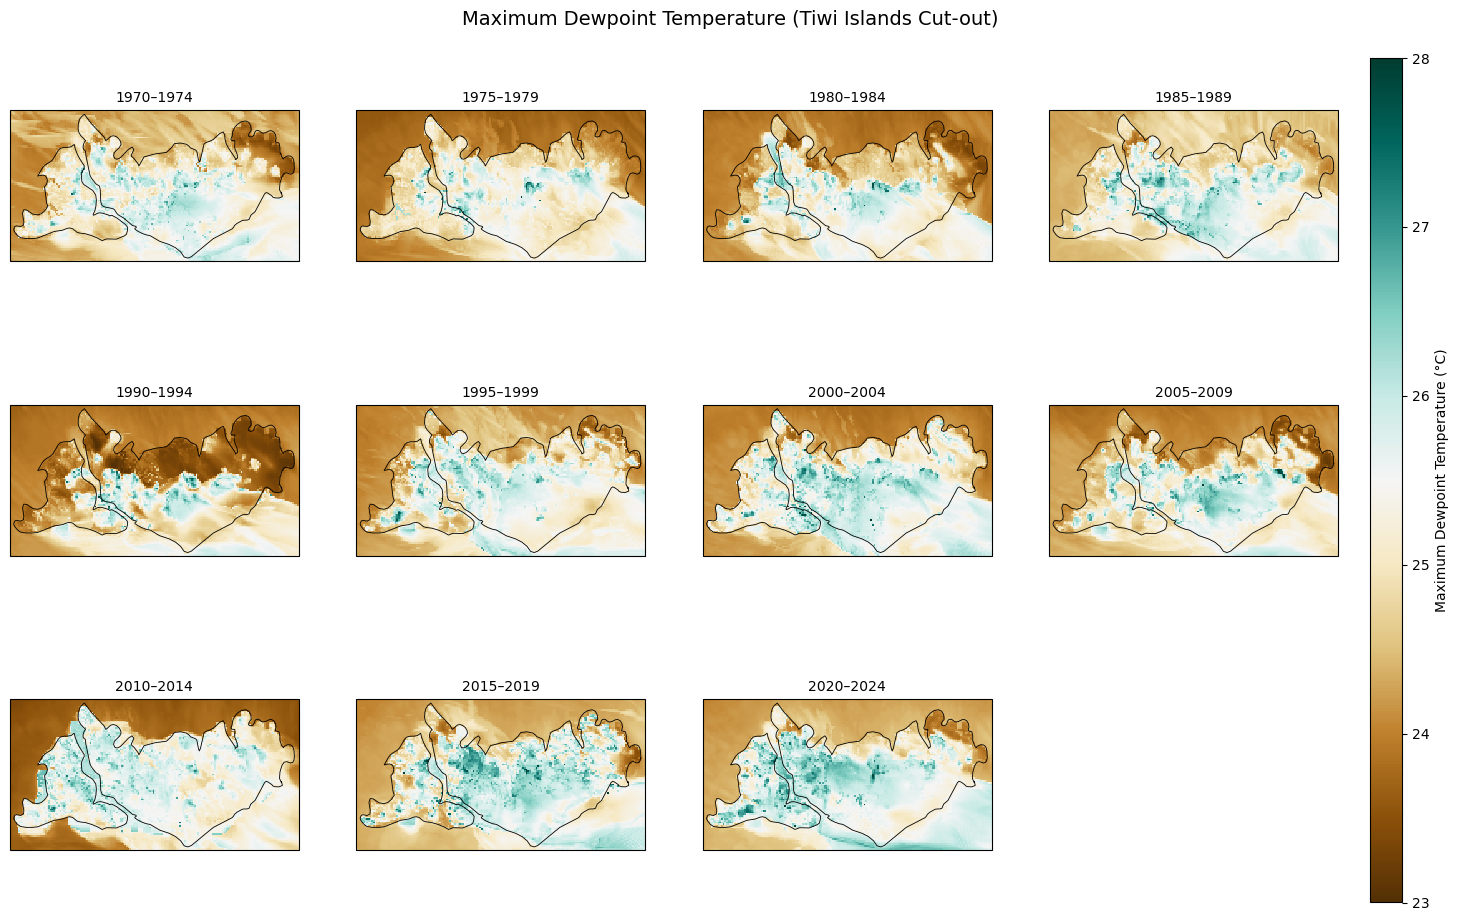

In [1]:
# Max dewpoint over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 23  # °C
vmax = 28  # °C
#cmap = "inferno"
cmap = "BrBG"  # dry (brown) → moist (blue)
# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Select 1.5 m height and remove fill values
    dew = ds["STASH_m01s03i250"].isel(height_1_5m=0).where(ds["STASH_m01s03i250"] > -1e8)
    
    # Convert from K to °C
    dew = dew - 273.15
    
    # Subset to cut-out area
    dew_subset = dew.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                         grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Maximum over time
    dew_max = dew_subset.max(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, dew_max,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Maximum Dewpoint Temperature (°C)")

fig.suptitle("Maximum Dewpoint Temperature (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


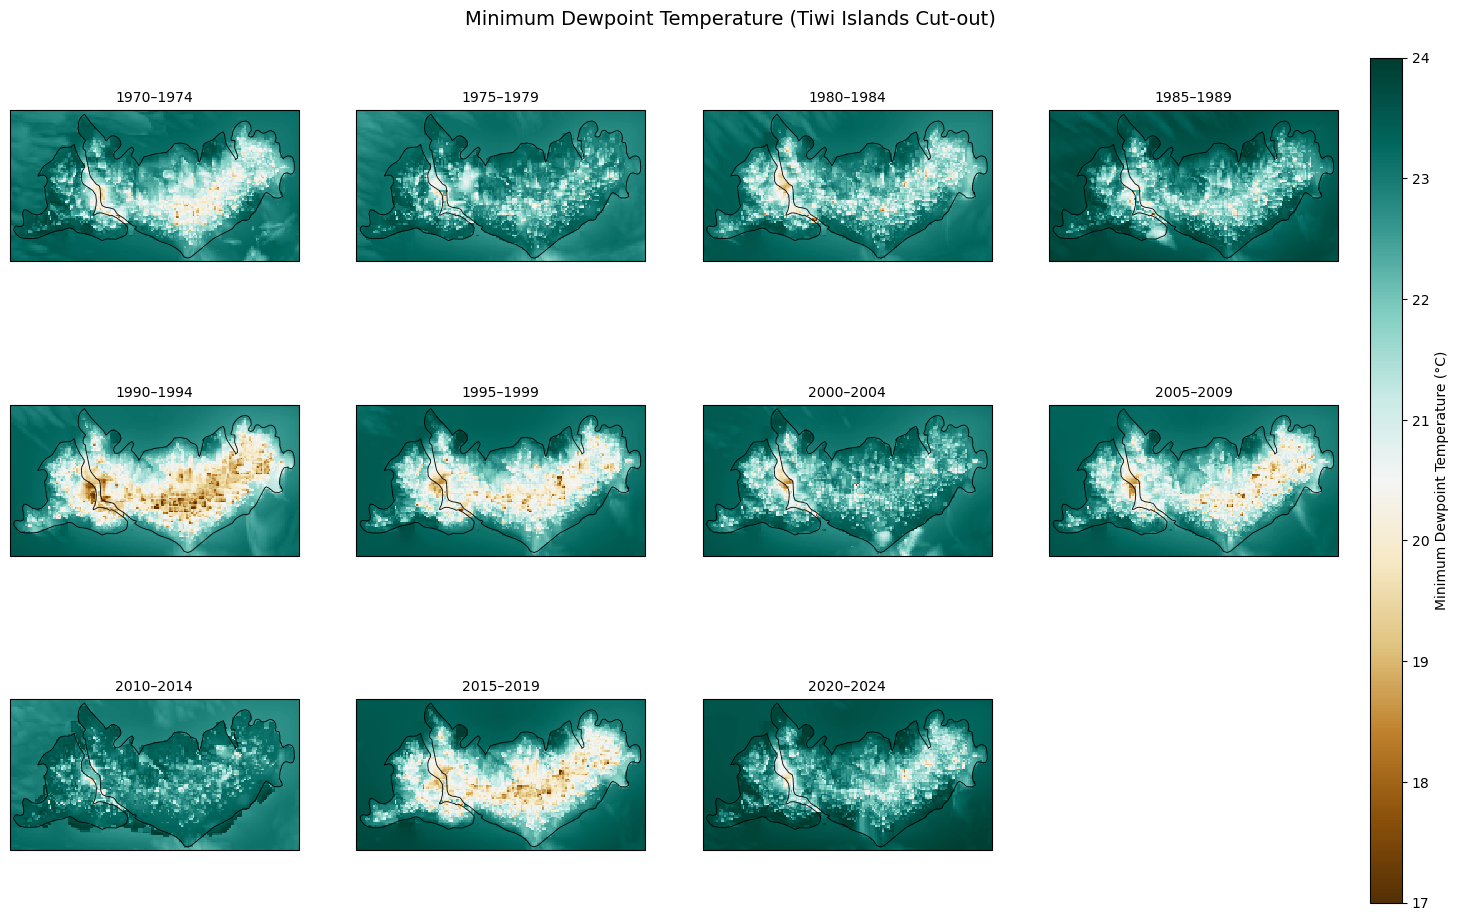

In [2]:
# Min dewpoint over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 17  # °C
vmax = 24  # °C
#cmap = "inferno_r"
#cmap = "cmo.haline_r"
cmap = "BrBG"  # dry (brown) → moist (blue)
# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Select 1.5 m height and remove fill values
    dew = ds["STASH_m01s03i250"].where(ds["STASH_m01s03i250"] > -1e8)
    
    # Convert from K to °C
    dew = dew - 273.15
    
    # Subset to cut-out area
    dew_subset = dew.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                         grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Minimum over time
    dew_min = dew_subset.min(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, dew_min,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Minimum Dewpoint Temperature (°C)")

fig.suptitle("Minimum Dewpoint Temperature (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


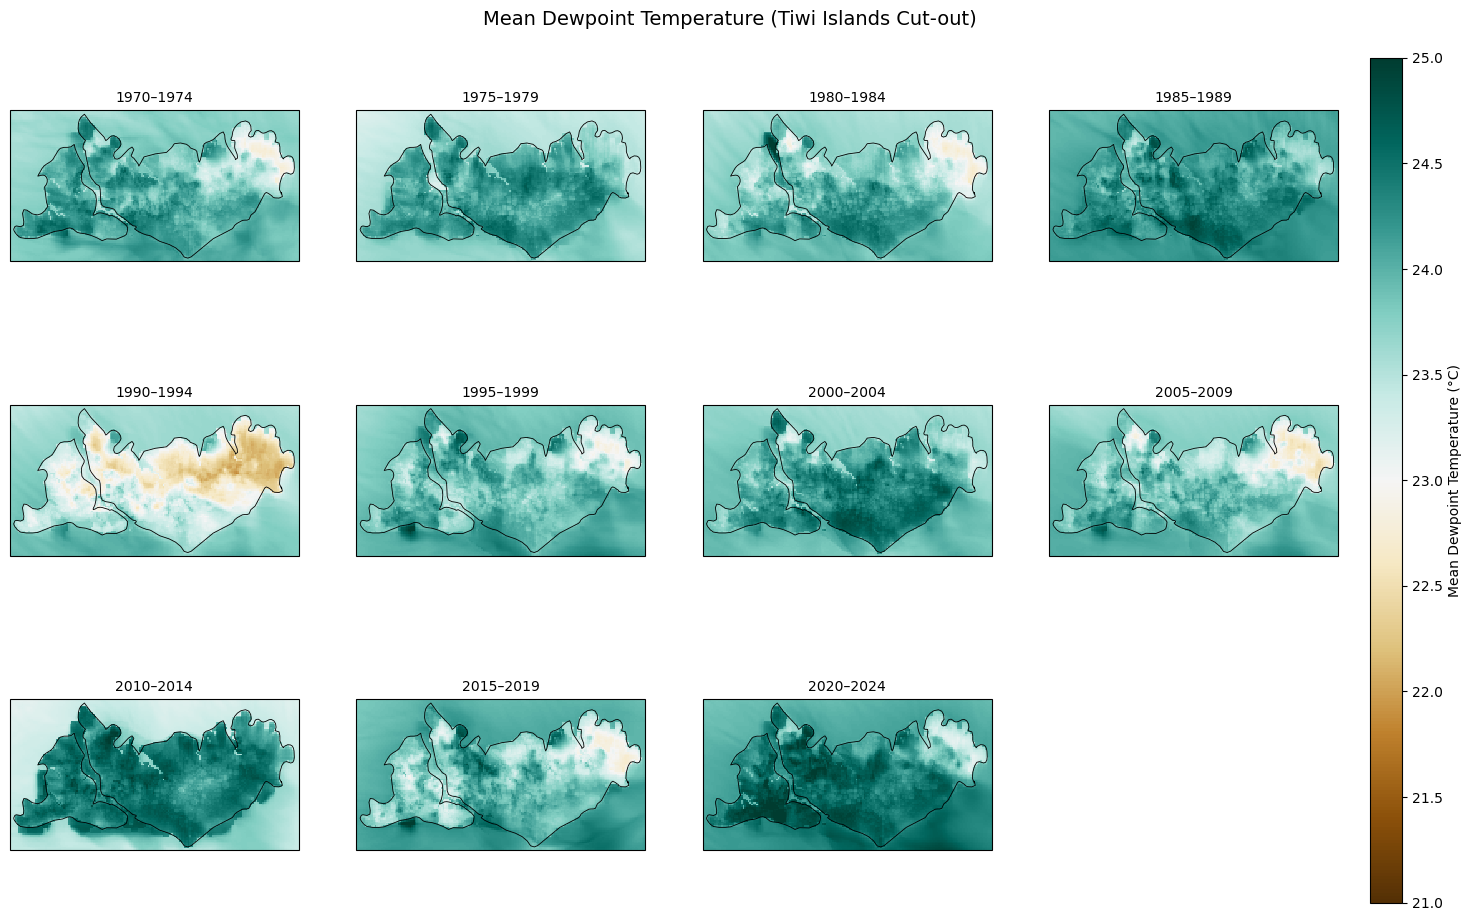

In [3]:
# Mean dewpoint temperature over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 21  # °C
vmax = 25  # °C
cmap = "BrBG"  # brown = dry, blue = moist

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Dewpoint temperature at 1.5 m (no height selection needed)
    dew = ds["STASH_m01s03i250"].where(ds["STASH_m01s03i250"] > -1e8)
    
    # Convert from K to °C
    dew = dew - 273.15
    
    # Subset to Tiwi Islands cut-out
    dew_subset = dew.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                         grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Mean over 12-hour simulation
    dew_mean = dew_subset.mean(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, dew_mean,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Mean Dewpoint Temperature (°C)")

fig.suptitle("Mean Dewpoint Temperature (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


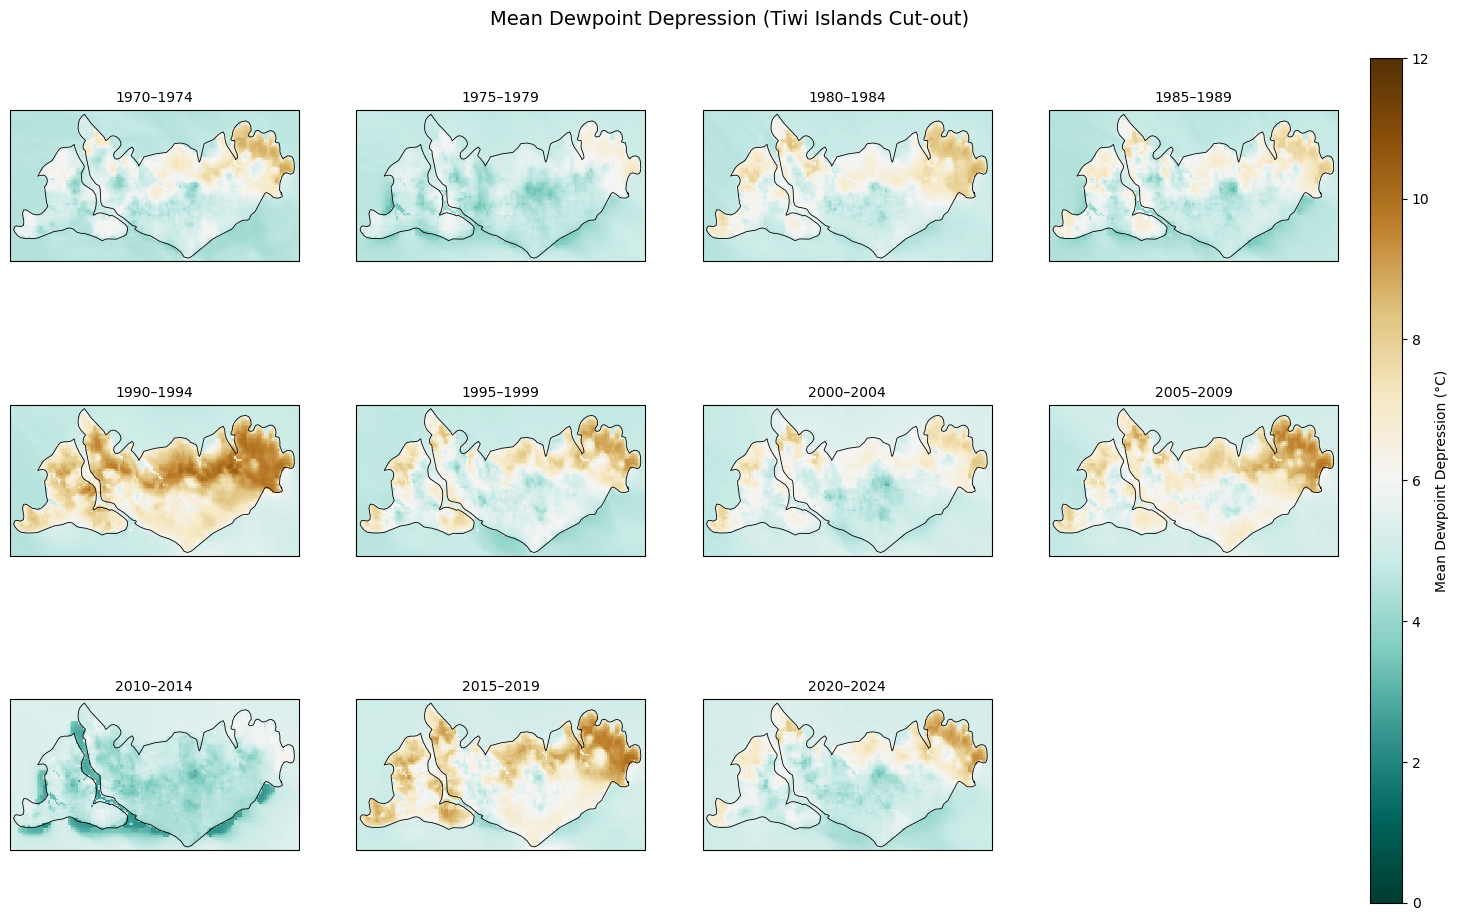

In [4]:
# Mean dewpoint depression over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 0   # °C
vmax = 12  # °C
cmap = "BrBG_r"  # brown = small depression (near-saturated), blue = large depression (dry)

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Air temperature and dewpoint at 1.5 m
    t_air = ds["STASH_m01s03i236"].where(ds["STASH_m01s03i236"] > -1e8) - 273.15
    t_dew = ds["STASH_m01s03i250"].where(ds["STASH_m01s03i250"] > -1e8) - 273.15
    
    # Subset to Tiwi Islands cut-out
    t_air_sub = t_air.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                          grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    t_dew_sub = t_dew.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                          grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Dewpoint depression
    dew_dep = t_air_sub - t_dew_sub
    
    # Mean over 12-hour simulation
    dew_dep_mean = dew_dep.mean(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, dew_dep_mean,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Mean Dewpoint Depression (°C)")

fig.suptitle("Mean Dewpoint Depression (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


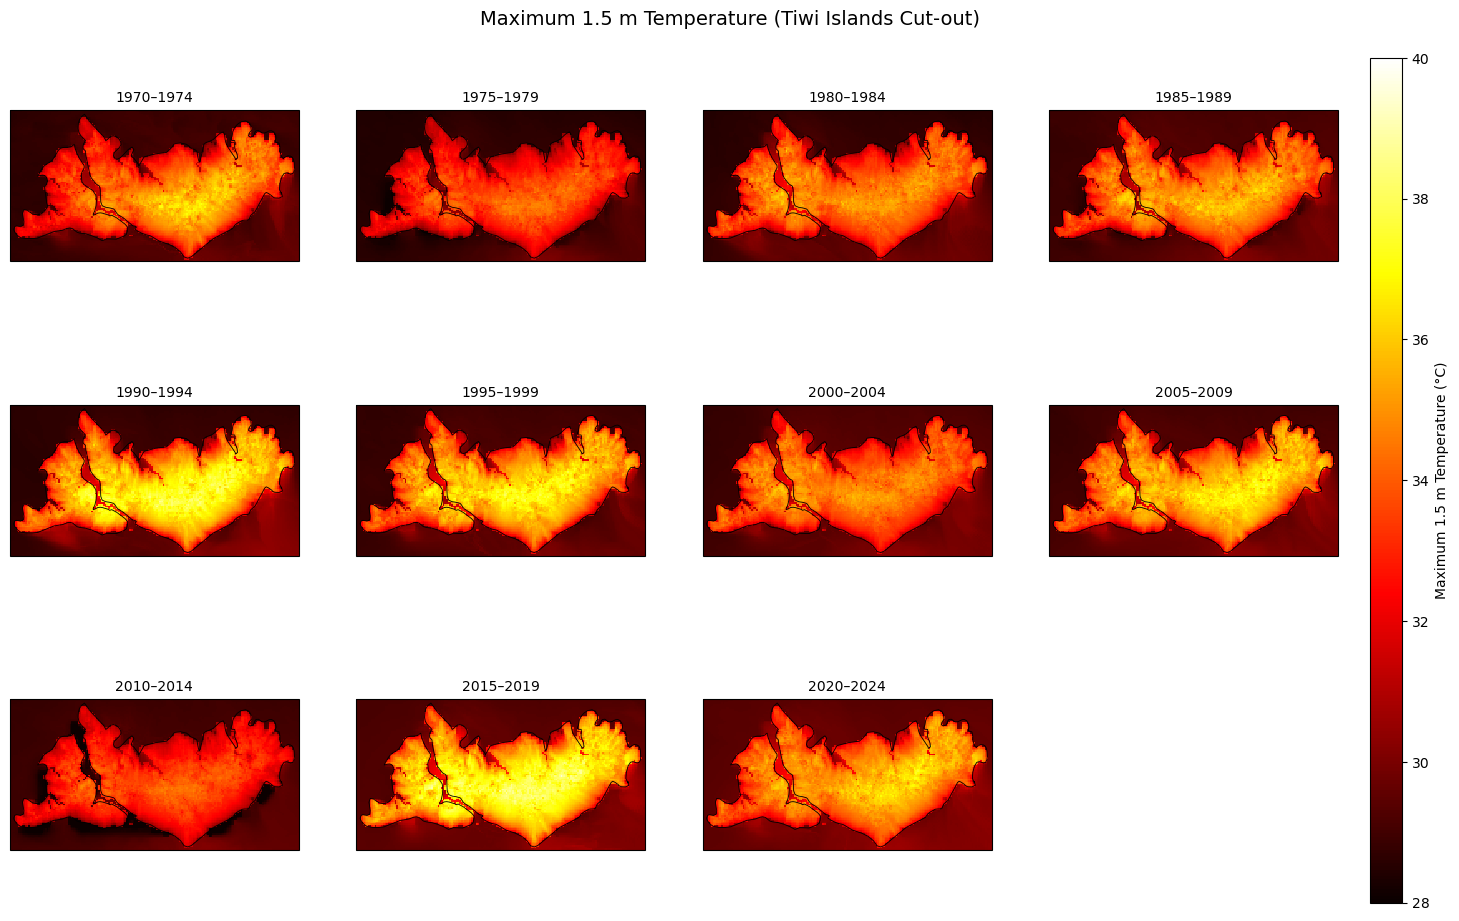

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 28  # °C (adjust as needed)
vmax = 40  # °C
cmap = "hot"

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Select 1.5 m height and remove fill values
    temp = ds["STASH_m01s03i236"].isel(height_1_5m=0).where(ds["STASH_m01s03i236"] > -1e8)
    
    # Convert from K to °C
    temp = temp - 273.15
    
    # Subset to cut-out area
    temp_subset = temp.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                           grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Maximum over time
    temp_max = temp_subset.max(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, temp_max,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Maximum 1.5 m Temperature (°C)")

fig.suptitle("Maximum 1.5 m Temperature (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


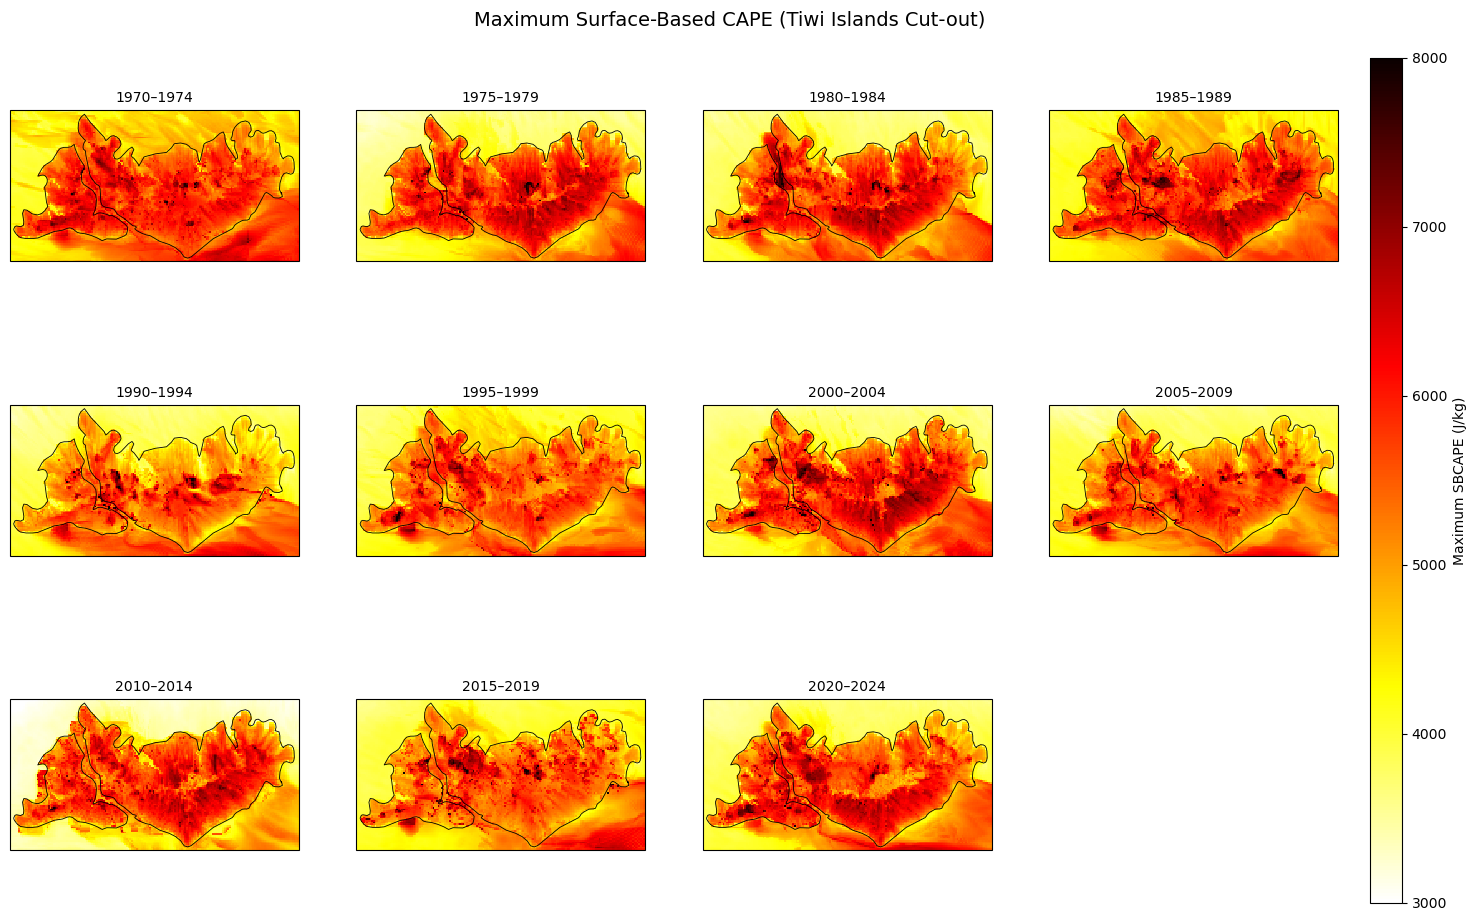

In [6]:
# Maximum surface-based CAPE over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 3000    # J/kg
vmax = 8000 # J/kg, adjust depending on your area
cmap = "hot_r"  # low CAPE = dark, high CAPE = bright yellow/red

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Surface-based CAPE
    cape = ds["STASH_m01s20i114"].where(ds["STASH_m01s20i114"] > -1e8)
    
    # Subset to Tiwi Islands cut-out
    cape_sub = cape.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                        grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Maximum over 12-hour simulation
    cape_max = cape_sub.max(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, cape_max,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Maximum SBCAPE (J/kg)")

fig.suptitle("Maximum Surface-Based CAPE (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


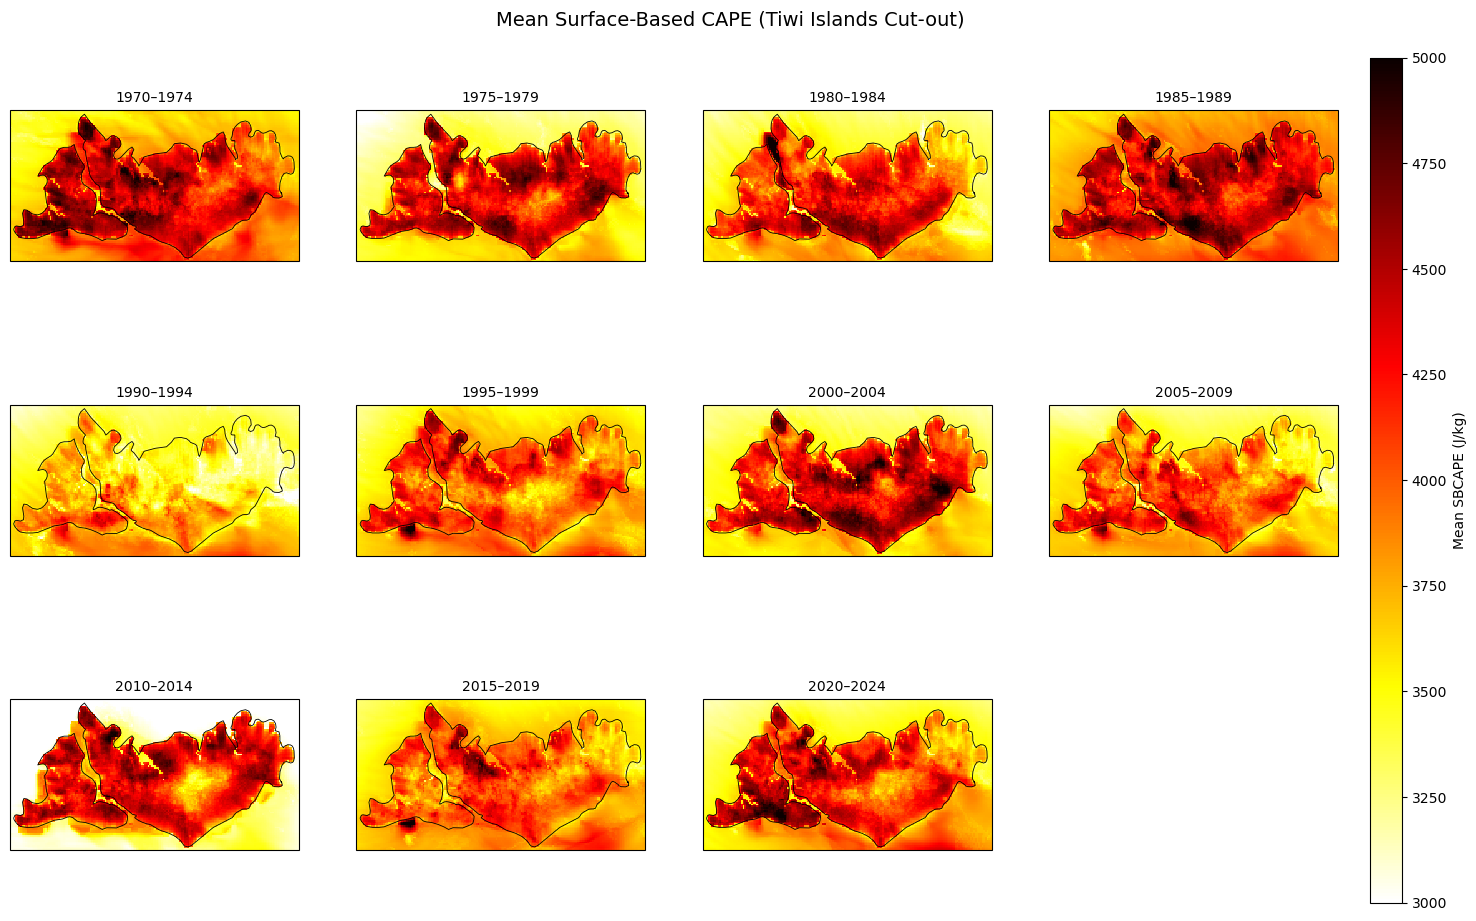

In [7]:
# Mean surface-based CAPE over the 12 hours of the simulations
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings
# -------------------
vmin = 3000    # J/kg
vmax = 5000 # J/kg, adjust depending on your area
cmap = "hot_r"  # low CAPE = dark, high CAPE = bright yellow/red

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path)
    
    # Surface-based CAPE
    cape = ds["STASH_m01s20i114"].where(ds["STASH_m01s20i114"] > -1e8)
    
    # Subset to Tiwi Islands cut-out
    cape_sub = cape.sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                        grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    lon_subset = ds["longitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                      grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    lat_subset = ds["latitude_t"].sel(grid_latitude_t=slice(lat_min_exp, lat_max_exp),
                                     grid_longitude_t=slice(lon_min_exp, lon_max_exp))
    
    # Mean over 12-hour simulation
    cape_mean = cape_sub.mean(dim="t5min").squeeze()
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, cape_mean,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.15, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Mean SBCAPE (J/kg)")

fig.suptitle("Mean Surface-Based CAPE (Tiwi Islands Cut-out)", fontsize=14)
plt.show()

Processing 1970–1974 ...
Processing 1975–1979 ...
Processing 1980–1984 ...
Processing 1985–1989 ...
Processing 1990–1994 ...
Processing 1995–1999 ...
Processing 2000–2004 ...
Processing 2005–2009 ...
Processing 2010–2014 ...
Processing 2015–2019 ...
Processing 2020–2024 ...


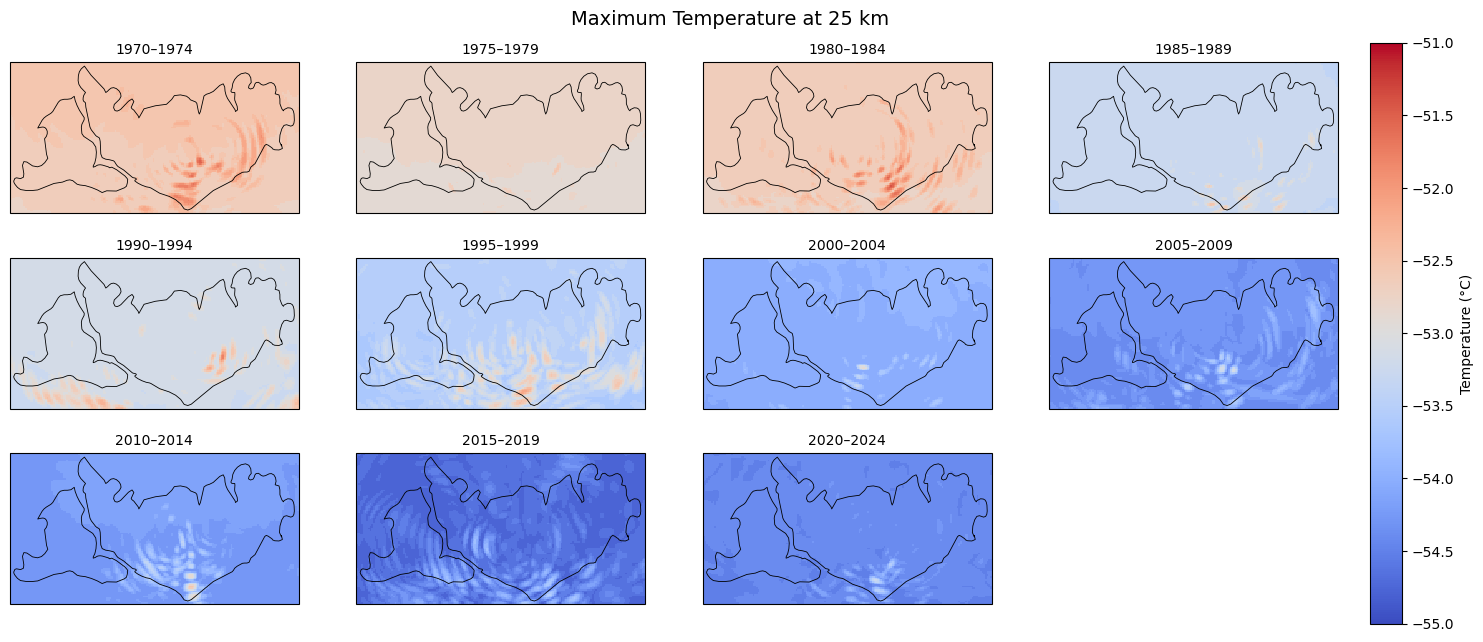

In [8]:
# Maximum 12 hour temperature at 25 km altitude (in the lower stratosphere)
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# -------------------
# Periods
# -------------------
periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_pa000.nc"),
]

# -------------------
# Tiwi Islands cut-out
# -------------------
lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

# -------------------
# Grid layout
# -------------------
ncols = 4
nrows = (len(periods) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2.2*nrows),
                         subplot_kw={"projection": ccrs.PlateCarree()})

# -------------------
# Plot settings - Adjust temperature range here
# -------------------
vmin = -55.0  # °C
vmax = -51.0  # °C
cmap = "coolwarm"

# -------------------
# Function to find nearest model level to target altitude
# -------------------
def nearest_level(height_array, target_height):
    idx = np.abs(height_array - target_height).argmin()
    return idx

# -------------------
# Loop over periods
# -------------------
for (label, path), ax in zip(periods, axes.flat):
    print(f"Processing {label} ...")
    ds = xr.open_dataset(path, chunks={"t5min": 24})  # chunk along time
    
    # Height array
    z = ds["TH_1_90_zsea_theta"].values
    level_idx = nearest_level(z, 25000.0)  # 10 km
    
    # Subset lat/lon and temperature
    temp = ds["STASH_m01s16i004"].sel(
        grid_latitude_t=slice(lat_min_exp, lat_max_exp),
        grid_longitude_t=slice(lon_min_exp, lon_max_exp)
    ).isel(TH_1_90_eta_theta=level_idx)
    
    temp = temp.where(temp > -1e8)
    
    # Maximum over time, convert to °C, squeeze dimensions, then compute
    temp_max = (temp.max(dim="t5min") - 273.15).squeeze().compute()
    
    lon_subset = ds["longitude_t"].sel(
        grid_latitude_t=slice(lat_min_exp, lat_max_exp),
        grid_longitude_t=slice(lon_min_exp, lon_max_exp)
    )
    lat_subset = ds["latitude_t"].sel(
        grid_latitude_t=slice(lat_min_exp, lat_max_exp),
        grid_longitude_t=slice(lon_min_exp, lon_max_exp)
    )
    
    # Plot
    pcm = ax.pcolormesh(lon_subset, lat_subset, temp_max,
                        cmap=cmap, vmin=vmin, vmax=vmax, shading="auto")
    ax.coastlines(resolution="10m", linewidth=0.6)
    ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=-1)
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=-1)
    ax.set_title(label, fontsize=10)

# Hide unused subplots
for ax in axes.flat[len(periods):]:
    ax.set_visible(False)

# -------------------
# Colorbar on the right
# -------------------
fig.subplots_adjust(left=0.05, right=0.88, top=0.93, bottom=0.05, hspace=0.03, wspace=0.2)
cbar_ax = fig.add_axes([0.90, 0.05, 0.02, 0.88])
cbar = fig.colorbar(pcm, cax=cbar_ax, label="Temperature (°C)")

# Main title automatically shows level height
height_value = z[level_idx]
fig.suptitle(f"Maximum Temperature at {height_value/1000:.0f} km", fontsize=14)

plt.show()

🌡 Processing 1970–1974 (1/11)...
   ✅ Done in 1.2 s
🌡 Processing 1975–1979 (2/11)...
   ✅ Done in 1.3 s
🌡 Processing 1980–1984 (3/11)...
   ✅ Done in 1.0 s
🌡 Processing 1985–1989 (4/11)...
   ✅ Done in 1.2 s
🌡 Processing 1990–1994 (5/11)...
   ✅ Done in 1.0 s
🌡 Processing 1995–1999 (6/11)...
   ✅ Done in 1.3 s
🌡 Processing 2000–2004 (7/11)...
   ✅ Done in 1.4 s
🌡 Processing 2005–2009 (8/11)...
   ✅ Done in 1.1 s
🌡 Processing 2010–2014 (9/11)...
   ✅ Done in 1.0 s
🌡 Processing 2015–2019 (10/11)...
   ✅ Done in 1.0 s
🌡 Processing 2020–2024 (11/11)...
   ✅ Done in 1.2 s
💾 Cached temperature data saved to tiwi_temp_1p5m_landmean_cache.npz


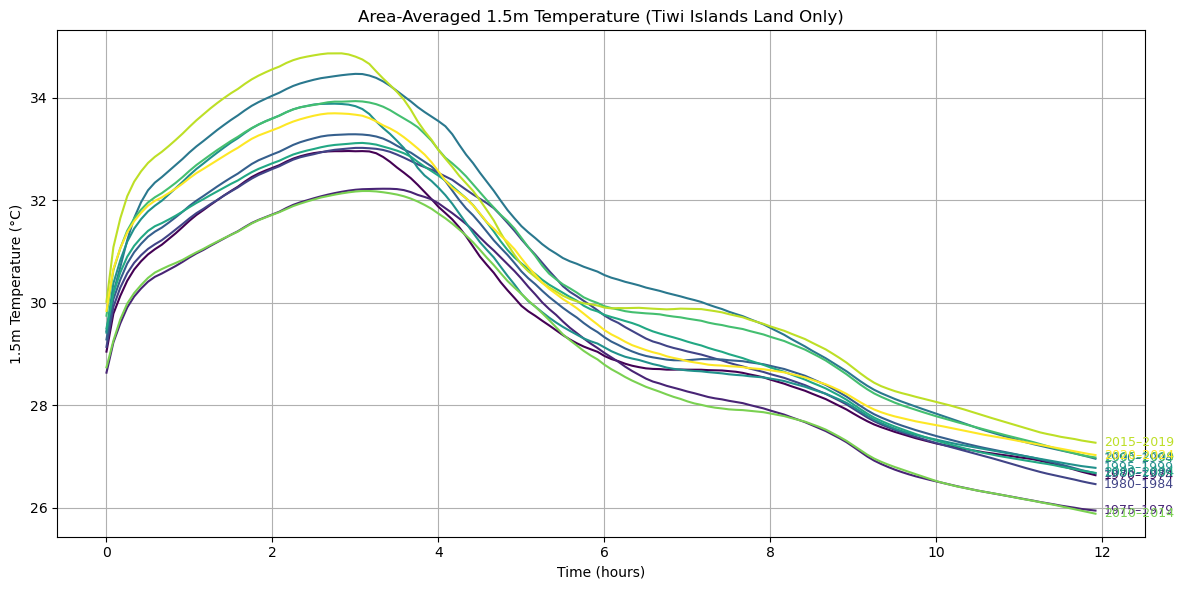

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
temp_var = "STASH_m01s03i236"       # 1.5m Temperature
land_var = "STASH_m01s00i030"       # Land mask
temp_cache_file = "tiwi_temp_1p5m_landmean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Load land mask once
# -------------------------------
land_ds = xr.open_dataset(periods[0][1])
lat_idx = np.where((land_ds.grid_latitude_t >= lat_min_exp) & (land_ds.grid_latitude_t <= lat_max_exp))[0]
lon_idx = np.where((land_ds.grid_longitude_t >= lon_min_exp) & (land_ds.grid_longitude_t <= lon_max_exp))[0]
land_mask = land_ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
land_mask = land_mask.astype(bool)
land_ds.close()

# -------------------------------
# Function to compute 1.5m temperature average over land
# -------------------------------
def compute_land_mean_temp(file_path, land_mask):
    ds = xr.open_dataset(file_path)
    
    # Select latitude/longitude indices and 1.5m height (assume first index)
    temp = ds[temp_var].isel(height_1_5m=0, grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    
    # Mask fill values
    fill_value = temp.attrs.get("_FillValue")
    if fill_value is not None:
        temp = temp.where(temp != fill_value)
    
    # Convert Kelvin → Celsius
    temp = temp - 273.15
    
    # Apply land mask
    temp_land = temp.where(land_mask)
    
    # Area average over land only
    domain_mean = temp_land.mean(dim=["grid_latitude_t", "grid_longitude_t"])
    
    ds.close()
    # Convert time to hours
    times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float) / 60.0
    return domain_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(temp_cache_file):
    try:
        data = np.load(temp_cache_file, allow_pickle=True)
        temp_mean = data["temp_mean"].item()
        temp_times = data["temp_times"].item()
        print(f"💾 Loaded cached data from {temp_cache_file}")
    except KeyError:
        temp_mean, temp_times = {}, {}
else:
    temp_mean, temp_times = {}, {}

if not temp_mean:
    for i, (label, path) in enumerate(periods):
        print(f"🌡 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            mean_temp, times = compute_land_mean_temp(path, land_mask)
            temp_mean[label] = mean_temp
            temp_times[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(temp_cache_file, temp_mean=temp_mean, temp_times=temp_times)
    print(f"💾 Cached temperature data saved to {temp_cache_file}")

# -------------------------------
# Plot area-averaged 1.5m temperature
# -------------------------------
plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0,1,len(periods)))

for i, (label, _) in enumerate(periods):
    if label in temp_mean:
        plt.plot(temp_times[label], temp_mean[label], color=colors[i])
        # Add label at the end
        plt.text(temp_times[label][-1]+0.1, temp_mean[label][-1], label,
                 color=colors[i], fontsize=9, va='center')

plt.xlabel("Time (hours)")
plt.ylabel("1.5m Temperature (°C)")
plt.title("Area-Averaged 1.5m Temperature (Tiwi Islands Land Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

🌡 Processing 1970–1974 (1/11)...
   ✅ Done in 1.1 s
🌡 Processing 1975–1979 (2/11)...
   ✅ Done in 1.2 s
🌡 Processing 1980–1984 (3/11)...
   ✅ Done in 1.3 s
🌡 Processing 1985–1989 (4/11)...
   ✅ Done in 1.4 s
🌡 Processing 1990–1994 (5/11)...
   ✅ Done in 1.3 s
🌡 Processing 1995–1999 (6/11)...
   ✅ Done in 1.8 s
🌡 Processing 2000–2004 (7/11)...
   ✅ Done in 1.4 s
🌡 Processing 2005–2009 (8/11)...
   ✅ Done in 1.7 s
🌡 Processing 2010–2014 (9/11)...
   ✅ Done in 1.4 s
🌡 Processing 2015–2019 (10/11)...
   ✅ Done in 1.3 s
🌡 Processing 2020–2024 (11/11)...
   ✅ Done in 1.3 s
💾 Cached data saved to tiwi_temp_dew_landmean_cache.npz


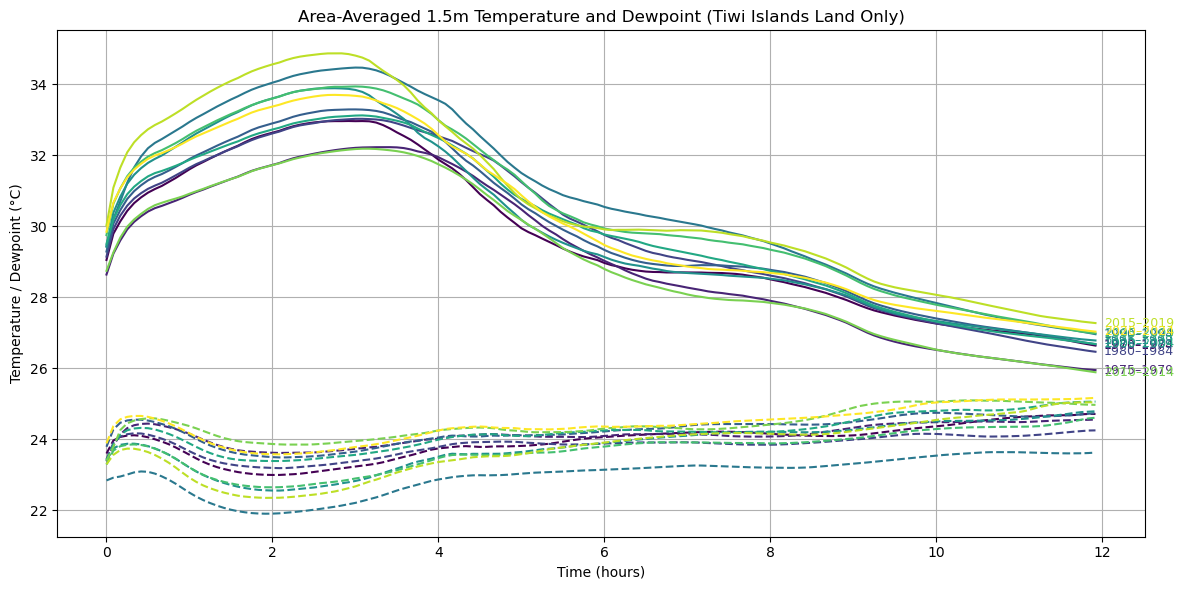

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
temp_var = "STASH_m01s03i236"       # 1.5m Temperature
dew_var = "STASH_m01s03i250"        # 1.5m Dewpoint
land_var = "STASH_m01s00i030"       # Land mask
cache_file = "tiwi_temp_dew_landmean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Load land mask once
# -------------------------------
land_ds = xr.open_dataset(periods[0][1])
lat_idx = np.where((land_ds.grid_latitude_t >= lat_min_exp) & (land_ds.grid_latitude_t <= lat_max_exp))[0]
lon_idx = np.where((land_ds.grid_longitude_t >= lon_min_exp) & (land_ds.grid_longitude_t <= lon_max_exp))[0]
land_mask = land_ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx).astype(bool)
land_ds.close()

# -------------------------------
# Function to compute 1.5m temp and dew over land
# -------------------------------
def compute_temp_dew(file_path, land_mask):
    ds = xr.open_dataset(file_path)

    # Temperature
    temp = ds[temp_var].isel(height_1_5m=0, grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    temp_fill = temp.attrs.get("_FillValue")
    if temp_fill is not None:
        temp = temp.where(temp != temp_fill)
    temp = temp - 273.15
    temp_land = temp.where(land_mask)
    temp_mean = temp_land.mean(dim=["grid_latitude_t","grid_longitude_t"])

    # Dewpoint
    dew = ds[dew_var].isel(height_1_5m=0, grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    dew_fill = dew.attrs.get("_FillValue")
    if dew_fill is not None:
        dew = dew.where(dew != dew_fill)
    dew = dew - 273.15
    dew_land = dew.where(land_mask)
    dew_mean = dew_land.mean(dim=["grid_latitude_t","grid_longitude_t"])

    # Time in hours
    times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float)/60.0
    ds.close()
    return temp_mean.values, dew_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(cache_file):
    try:
        data = np.load(cache_file, allow_pickle=True)
        temp_mean = data["temp_mean"].item()
        dew_mean = data["dew_mean"].item()
        times_vals = data["times_vals"].item()
        print(f"💾 Loaded cached data from {cache_file}")
    except KeyError:
        temp_mean, dew_mean, times_vals = {}, {}, {}
else:
    temp_mean, dew_mean, times_vals = {}, {}, {}

if not temp_mean:
    for i, (label, path) in enumerate(periods):
        print(f"🌡 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            t_mean, d_mean, times = compute_temp_dew(path, land_mask)
            temp_mean[label] = t_mean
            dew_mean[label] = d_mean
            times_vals[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(cache_file, temp_mean=temp_mean, dew_mean=dew_mean, times_vals=times_vals)
    print(f"💾 Cached data saved to {cache_file}")

# -------------------------------
# Plot temperature and dewpoint
# -------------------------------
plt.figure(figsize=(12,6))
colors = plt.cm.viridis(np.linspace(0,1,len(periods)))

for i, (label, _) in enumerate(periods):
    if label in temp_mean:
        plt.plot(times_vals[label], temp_mean[label], color=colors[i], label=None)   # solid temp
        plt.plot(times_vals[label], dew_mean[label], color=colors[i], linestyle='--', label=None)  # dashed dew
        # Labels at the end
        plt.text(times_vals[label][-1]+0.1, temp_mean[label][-1], label, color=colors[i], fontsize=9, va='center')

plt.xlabel("Time (hours)")
plt.ylabel("Temperature / Dewpoint (°C)")
plt.title("Area-Averaged 1.5m Temperature and Dewpoint (Tiwi Islands Land Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

💾 Loaded cached data from tiwi_temp_dew_landmean_cache.npz


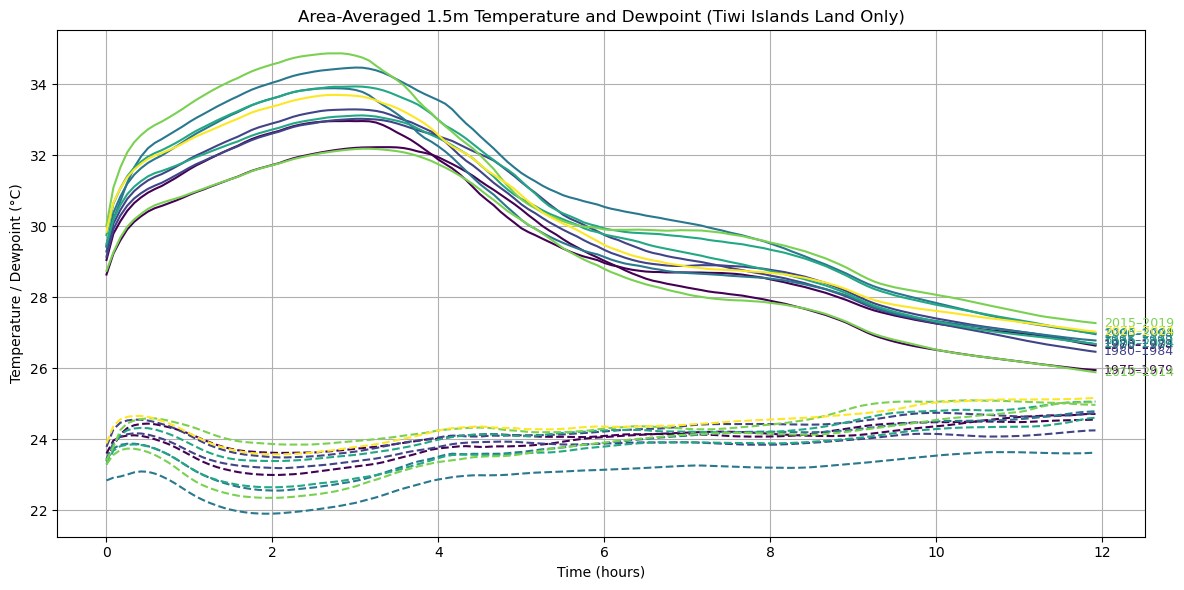

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
temp_var = "STASH_m01s03i236"       # 1.5m Temperature
dew_var = "STASH_m01s03i250"        # 1.5m Dewpoint
land_var = "STASH_m01s00i030"       # Land mask
cache_file = "tiwi_temp_dew_landmean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Assign decade for each period
# -------------------------------
def get_decade(label):
    start_year = int(label.split('–')[0])
    return (start_year // 10) * 10

decades = sorted({get_decade(label) for label, _ in periods})
colors = plt.cm.viridis(np.linspace(0,1,len(decades)))
decade_color_map = {decade: colors[i] for i, decade in enumerate(decades)}

# -------------------------------
# Load land mask once
# -------------------------------
land_ds = xr.open_dataset(periods[0][1])
lat_idx = np.where((land_ds.grid_latitude_t >= lat_min_exp) & (land_ds.grid_latitude_t <= lat_max_exp))[0]
lon_idx = np.where((land_ds.grid_longitude_t >= lon_min_exp) & (land_ds.grid_longitude_t <= lon_max_exp))[0]
land_mask = land_ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx).astype(bool)
land_ds.close()

# -------------------------------
# Function to compute 1.5m temp and dew over land
# -------------------------------
def compute_temp_dew(file_path, land_mask):
    ds = xr.open_dataset(file_path)
    temp = ds[temp_var].isel(height_1_5m=0, grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    temp_fill = temp.attrs.get("_FillValue")
    if temp_fill is not None:
        temp = temp.where(temp != temp_fill)
    temp = temp - 273.15
    temp_mean = temp.where(land_mask).mean(dim=["grid_latitude_t","grid_longitude_t"])
    
    dew = ds[dew_var].isel(height_1_5m=0, grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    dew_fill = dew.attrs.get("_FillValue")
    if dew_fill is not None:
        dew = dew.where(dew != dew_fill)
    dew = dew - 273.15
    dew_mean = dew.where(land_mask).mean(dim=["grid_latitude_t","grid_longitude_t"])
    
    times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float)/60.0
    ds.close()
    return temp_mean.values, dew_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(cache_file):
    try:
        data = np.load(cache_file, allow_pickle=True)
        temp_mean = data["temp_mean"].item()
        dew_mean = data["dew_mean"].item()
        times_vals = data["times_vals"].item()
        print(f"💾 Loaded cached data from {cache_file}")
    except KeyError:
        temp_mean, dew_mean, times_vals = {}, {}, {}
else:
    temp_mean, dew_mean, times_vals = {}, {}, {}

if not temp_mean:
    for i, (label, path) in enumerate(periods):
        print(f"🌡 Processing {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            t_mean, d_mean, times = compute_temp_dew(path, land_mask)
            temp_mean[label] = t_mean
            dew_mean[label] = d_mean
            times_vals[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(cache_file, temp_mean=temp_mean, dew_mean=dew_mean, times_vals=times_vals)
    print(f"💾 Cached data saved to {cache_file}")

# -------------------------------
# Plot temperature and dewpoint
# -------------------------------
plt.figure(figsize=(12,6))

for label, _ in periods:
    if label in temp_mean:
        decade = get_decade(label)
        color = decade_color_map[decade]
        plt.plot(times_vals[label], temp_mean[label], color=color)        # solid temp
        plt.plot(times_vals[label], dew_mean[label], color=color, linestyle='--')  # dashed dew
        plt.text(times_vals[label][-1]+0.1, temp_mean[label][-1], label, color=color, fontsize=9, va='center')

plt.xlabel("Time (hours)")
plt.ylabel("Temperature / Dewpoint (°C)")
plt.title("Area-Averaged 1.5m Temperature and Dewpoint (Tiwi Islands Land Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

☁️ Processing CAPE 1970–1974 (1/11)...
   ✅ Done in 1.3 s
☁️ Processing CAPE 1975–1979 (2/11)...
   ✅ Done in 0.6 s
☁️ Processing CAPE 1980–1984 (3/11)...
   ✅ Done in 1.1 s
☁️ Processing CAPE 1985–1989 (4/11)...
   ✅ Done in 1.2 s
☁️ Processing CAPE 1990–1994 (5/11)...
   ✅ Done in 1.1 s
☁️ Processing CAPE 1995–1999 (6/11)...
   ✅ Done in 1.3 s
☁️ Processing CAPE 2000–2004 (7/11)...
   ✅ Done in 1.3 s
☁️ Processing CAPE 2005–2009 (8/11)...
   ✅ Done in 1.1 s
☁️ Processing CAPE 2010–2014 (9/11)...
   ✅ Done in 1.0 s
☁️ Processing CAPE 2015–2019 (10/11)...
   ✅ Done in 1.0 s
☁️ Processing CAPE 2020–2024 (11/11)...
   ✅ Done in 1.1 s
💾 Cached CAPE data saved to tiwi_cape_landmean_cache.npz


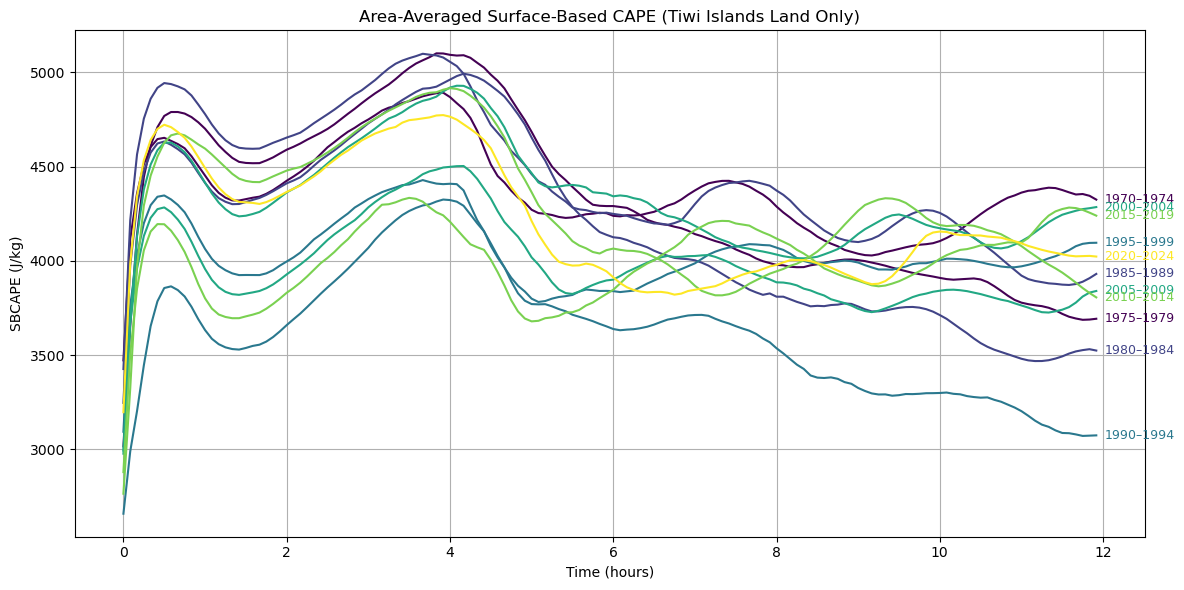

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -------------------------------
# Settings
# -------------------------------
cape_var = "STASH_m01s20i114"      # SBCAPE (J/kg)
land_var = "STASH_m01s00i030"      # Land mask
cache_file = "tiwi_cape_landmean_cache.npz"

lat_min_exp = -11.95
lat_max_exp = -11.13
lon_min_exp = 130.0
lon_max_exp = 131.56

periods = [
    ("1970–1974", "/g/data/gx60/experiments/2025-06-11_tiwi/19701101T0000Z/Tiwi_12h_1970-1974_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1975–1979", "/g/data/gx60/experiments/2025-06-11_tiwi/19751101T0000Z/Tiwi_12h_1975-1979_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1980–1984", "/g/data/gx60/experiments/2025-06-11_tiwi/19801101T0000Z/Tiwi_12h_1980-1984_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1985–1989", "/g/data/gx60/experiments/2025-06-11_tiwi/19851101T0000Z/Tiwi_12h_1985-1989_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1990–1994", "/g/data/gx60/experiments/2025-06-11_tiwi/19901101T0000Z/Tiwi_12h_1990-1994_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("1995–1999", "/g/data/gx60/experiments/2025-06-11_tiwi/19951101T0000Z/Tiwi_12h_1995-1999_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2000–2004", "/g/data/gx60/experiments/2025-06-11_tiwi/20001101T0000Z/Tiwi_12h_2000-2004_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2005–2009", "/g/data/gx60/experiments/2025-06-11_tiwi/20051101T0000Z/Tiwi_12h_2005-2009_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2010–2014", "/g/data/gx60/experiments/2025-06-11_tiwi/20101101T0000Z/Tiwi_12h_2010-2014_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2015–2019", "/g/data/gx60/experiments/2025-06-11_tiwi/20151101T0000Z/Tiwi_12h_2015-2019_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
    ("2020–2024", "/g/data/gx60/experiments/2025-06-11_tiwi/20201101T0000Z/Tiwi_12h_2020-2024_windzero/Tiwi_1/RAL3P2/um/umnsaa_sfc000.nc"),
]

# -------------------------------
# Assign decade for each period
# -------------------------------
def get_decade(label):
    start_year = int(label.split('–')[0])
    return (start_year // 10) * 10

decades = sorted({get_decade(label) for label, _ in periods})
colors = plt.cm.viridis(np.linspace(0,1,len(decades)))
decade_color_map = {decade: colors[i] for i, decade in enumerate(decades)}

# -------------------------------
# Load land mask once
# -------------------------------
land_ds = xr.open_dataset(periods[0][1])
lat_idx = np.where((land_ds.grid_latitude_t >= lat_min_exp) & (land_ds.grid_latitude_t <= lat_max_exp))[0]
lon_idx = np.where((land_ds.grid_longitude_t >= lon_min_exp) & (land_ds.grid_longitude_t <= lon_max_exp))[0]
land_mask = land_ds[land_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx).astype(bool)
land_ds.close()

# -------------------------------
# Function to compute CAPE over land
# -------------------------------
def compute_cape(file_path, land_mask):
    ds = xr.open_dataset(file_path)
    cape = ds[cape_var].isel(grid_latitude_t=lat_idx, grid_longitude_t=lon_idx)
    fill_value = cape.attrs.get("_FillValue")
    if fill_value is not None:
        cape = cape.where(cape != fill_value)
    cape_mean = cape.where(land_mask).mean(dim=["grid_latitude_t","grid_longitude_t"])
    
    times_hr = (ds.t5min.values - ds.t5min.values[0]).astype("timedelta64[m]").astype(float)/60.0
    ds.close()
    return cape_mean.values, times_hr

# -------------------------------
# Load or compute cache
# -------------------------------
if os.path.exists(cache_file):
    try:
        data = np.load(cache_file, allow_pickle=True)
        cape_mean = data["cape_mean"].item()
        times_vals = data["times_vals"].item()
        print(f"💾 Loaded cached CAPE data from {cache_file}")
    except KeyError:
        cape_mean, times_vals = {}, {}
else:
    cape_mean, times_vals = {}, {}

if not cape_mean:
    for i, (label, path) in enumerate(periods):
        print(f"☁️ Processing CAPE {label} ({i+1}/{len(periods)})...")
        start = time.time()
        try:
            c_mean, times = compute_cape(path, land_mask)
            cape_mean[label] = c_mean
            times_vals[label] = times
            print(f"   ✅ Done in {time.time() - start:.1f} s")
        except Exception as e:
            print(f"   ⚠️ Skipping {label}: {e}")
            continue
    np.savez(cache_file, cape_mean=cape_mean, times_vals=times_vals)
    print(f"💾 Cached CAPE data saved to {cache_file}")

# -------------------------------
# Plot CAPE
# -------------------------------
plt.figure(figsize=(12,6))
for label, _ in periods:
    if label in cape_mean:
        decade = get_decade(label)
        color = decade_color_map[decade]
        plt.plot(times_vals[label], cape_mean[label], color=color)
        plt.text(times_vals[label][-1]+0.1, cape_mean[label][-1], label, color=color, fontsize=9, va='center')

plt.xlabel("Time (hours)")
plt.ylabel("SBCAPE (J/kg)")
plt.title("Area-Averaged Surface-Based CAPE (Tiwi Islands Land Only)")
plt.grid(True)
plt.tight_layout()
plt.show()